In [ ]:
import argparse
import copy
import os
import logging
import trimesh
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
from bop_toolkit_lib import dataset_params, inout, misc, visualization
from bop_toolkit_lib.rendering import renderer
from bop_toolkit_lib.common_utils import adjust_img_for_plt
from bop_toolkit_lib.contour_vis import get_depth_map_and_obj_masks_from_renderings, draw_pose_contour
from bop_toolkit_lib.vis_utils import calc_mask_visib_percent, pose_dict_to_mat
from bop_toolkit_lib.bbox_vis import draw_pose_on_img

                mandatory if you are running evaluation on HOT3d.
                Refer to the README.md for installation instructions.
                


In [ ]:
logger = misc.get_logger("demo")
logger.setLevel(logging.INFO)

htt_available = False

args = argparse.Namespace(
    **{
        "datasets_path": Path("../../data"),
        "n_top": -1,
        "renderer_type": "vispy",
        "vis_depth_diff": True,
        "vis_orig_color": False,
        "vis_path": "./outputs",  # visuals will be stored here
        "vis_per_obj_id": False,
        "vis_rgb": True,
        "vis_rgb_resolve_visib": True,
    }
)
assert args.datasets_path.exists(), args.datasets_path.absolute()

In [4]:
dataset = "hopev2"
ds_to_scene_im_ids = {"hopev2": {8: [0], 3: [0]}}  # ds -> scene_id -> im_ids
split = "val"
split_type = None

split_path = Path(args.datasets_path) / dataset / split
assert split_path.exists(), split_path

# Load colors.
colors_path = os.path.join(os.path.dirname(visualization.__file__), "colors.json")
colors = inout.load_json(colors_path)

# Path templates for output images.
vis_rgb_tpath = os.path.join(
    "{vis_path}", "{result_name}", "{scene_id:06d}", "{vis_name}.jpg"
)
vis_depth_diff_tpath = os.path.join(
    "{vis_path}", "{result_name}", "{scene_id:06d}", "{vis_name}_depth_diff.jpg"
)

# Load dataset parameters.
dp_split = dataset_params.get_split_params(
    args.datasets_path, dataset, split, split_type
)

model_type = "eval"
dp_model = dataset_params.get_model_params(args.datasets_path, dataset, model_type)

# Rendering mode.
renderer_modalities = []
if args.vis_rgb:
    renderer_modalities.append("rgb")
if args.vis_depth_diff or (args.vis_rgb and args.vis_rgb_resolve_visib):
    renderer_modalities.append("depth")
renderer_mode = "+".join(renderer_modalities)

models = {}
for obj_id in dp_model["obj_ids"]:
    models[obj_id] = inout.load_ply(dp_model["model_tpath"].format(obj_id=obj_id))
models_info = inout.load_json(dp_model["models_info_path"], keys_to_int=True)
hw = dp_split["im_size"][::-1]
width, height = None, None
ren = None
res_all = []

for scene_id, im_ids in ds_to_scene_im_ids[dataset].items():
    tpath_keys = dataset_params.scene_tpaths_keys(
        dp_split["eval_modality"], dp_split["eval_sensor"], scene_id
    )
    scene_modality = dataset_params.get_scene_sensor_or_modality(
        dp_split["eval_modality"], scene_id
    )
    scene_sensor = dataset_params.get_scene_sensor_or_modality(
        dp_split["eval_sensor"], scene_id
    )

    # Create a new renderer if image size has changed
    scene_width, scene_height = dataset_params.get_im_size(
        dp_split, scene_modality, scene_sensor
    )
    if (width, height) != (scene_width, scene_height):
        width, height = scene_width, scene_height
        logger.info(f"Creating renderer of type {args.renderer_type}")
        ren = renderer.create_renderer(
            width,
            height,
            args.renderer_type,
            mode=renderer_mode,
            shading="flat",
        )
        logging.getLogger("vispy").setLevel(logging.ERROR)
        # Load object models in the new renderer.
        for obj_id in dp_model["obj_ids"]:
            model_path = dp_model["model_tpath"].format(obj_id=obj_id)
            model_color = None
            if not args.vis_orig_color:
                model_color = tuple(colors[(obj_id - 1) % len(colors)])
            ren.add_object(obj_id, model_path, surf_color=model_color)

    # Load info and ground-truth poses for the current scene.
    scene_camera = inout.load_scene_camera(
        dp_split[tpath_keys["scene_camera_tpath"]].format(scene_id=scene_id)
    )
    scene_gt = inout.load_scene_gt(
        dp_split[tpath_keys["scene_gt_tpath"]].format(scene_id=scene_id)
    )

    for im_ind, im_id in enumerate(im_ids):
        if im_id not in ds_to_scene_im_ids[dataset][scene_id]:
            continue
        if im_id not in scene_gt:
            continue
        split_type_str = " - " + split_type if split_type is not None else ""
        logger.info(f"Processing {dataset=}{split_type_str} {scene_id=} {im_id=}")

        # Retrieve camera intrinsics.
        cam = scene_camera[im_id]["cam_K"]

        im_ests_vis = scene_gt[im_id]
        im_ests_vis_obj_ids = [x["obj_id"] for x in im_ests_vis]

        # Load the color and depth images and prepare images for rendering.
        rgb = None
        if args.vis_rgb:
            # rgb_tpath is an alias refering to the sensor|modality image paths on which the poses are rendered
            im_tpath = tpath_keys["rgb_tpath"]
            # check for BOP classic (itodd)
            rgb_available = dataset_params.sensor_has_modality(
                dp_split, scene_sensor, "rgb"
            )
            if im_tpath == "rgb_tpath" and not rgb_available:
                im_tpath = "gray_tpath"

            rgb = inout.load_im(
                dp_split[im_tpath].format(scene_id=scene_id, im_id=im_id)
            )
            # if image is grayscale (e.g. quest3), convert it to 3 channels
            if rgb.ndim == 2:
                rgb = np.dstack([rgb, rgb, rgb])
            else:
                rgb = rgb[:, :, :3]  # should we keep this?

        depth = None
        if args.vis_depth_diff or (args.vis_rgb and args.vis_rgb_resolve_visib):
            depth_available = dataset_params.sensor_has_modality(
                dp_split, scene_sensor, "depth"
            )
            if not depth_available:
                logger.info(
                    f"{scene_sensor} has no depth data, skipping depth visualization"
                )
                args.vis_depth_diff = False
                args.vis_rgb_resolve_visib = False
            else:
                depth = inout.load_depth(
                    dp_split[tpath_keys["depth_tpath"]].format(
                        scene_id=scene_id, im_id=im_id
                    )
                )
                depth *= scene_camera[im_id]["depth_scale"]  # Convert to [mm].

        # Visualization name.
        vis_name = "{im_id:06d}".format(im_id=im_id)

        # Path to the output RGB visualization.
        vis_rgb_path = None
        if args.vis_rgb:
            vis_rgb_path = vis_rgb_tpath.format(
                vis_path=args.vis_path,
                result_name="gt",
                scene_id=scene_id,
                vis_name=vis_name,
            )

        # Path to the output depth difference visualization.
        vis_depth_diff_path = None
        if args.vis_depth_diff:
            vis_depth_diff_path = vis_depth_diff_tpath.format(
                vis_path=args.vis_path,
                result_name="gt",
                scene_id=scene_id,
                vis_name=vis_name,
            )

        # Visualization.

        gt_poses = [
            {
                "R": o["cam_R_m2c"],
                "t": o["cam_t_m2c"],
                "obj_id": o["obj_id"],
            }
            for o in scene_gt[im_id]
        ]
        est_poses = copy.deepcopy(gt_poses)
        for p in est_poses:
            noise_rot = R.from_euler(
                "xyz", np.random.randn(3) * 5, degrees=True
            ).as_matrix()
            p["R"] = noise_rot @ p["R"]
            noise_t = np.random.randn(3) * 0.01
            p["t"] = p["t"].squeeze() + noise_t

        res = visualization.vis_object_poses(
            poses=est_poses,
            K=cam,
            renderer=ren,
            rgb=rgb,
            depth=depth,
            vis_rgb_path=vis_rgb_path,
            vis_depth_diff_path=vis_depth_diff_path,
            vis_rgb_resolve_visib=args.vis_rgb_resolve_visib,
        )
        res_gt = visualization.vis_object_poses(
            poses=gt_poses,
            K=cam,
            renderer=ren,
            rgb=rgb,
            depth=depth,
            vis_rgb_path=vis_rgb_path,
            vis_depth_diff_path=vis_depth_diff_path,
            vis_rgb_resolve_visib=args.vis_rgb_resolve_visib,
        )
        res_all.append(
            {
                "scene_id": scene_id,
                "rgb": rgb,
                "depth": depth,
                "im_id": im_id,
                "res": res,
                "res_gt": res_gt,
                "cam": cam,
            }
        )

INFO:demo:Creating renderer of type vispy


vispy uses app: egl, gl: gl2


INFO:demo:Processing dataset='hopev2' scene_id=8 im_id=0
/home/master/.conda/envs/bop/lib/python3.10/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
INFO:demo:Processing dataset='hopev2' scene_id=3 im_id=0


contour:   0%|          | 0/21 [00:00<?, ?it/s]

bbox:   0%|          | 0/21 [00:00<?, ?it/s]

contour:   0%|          | 0/20 [00:00<?, ?it/s]

bbox:   0%|          | 0/20 [00:00<?, ?it/s]

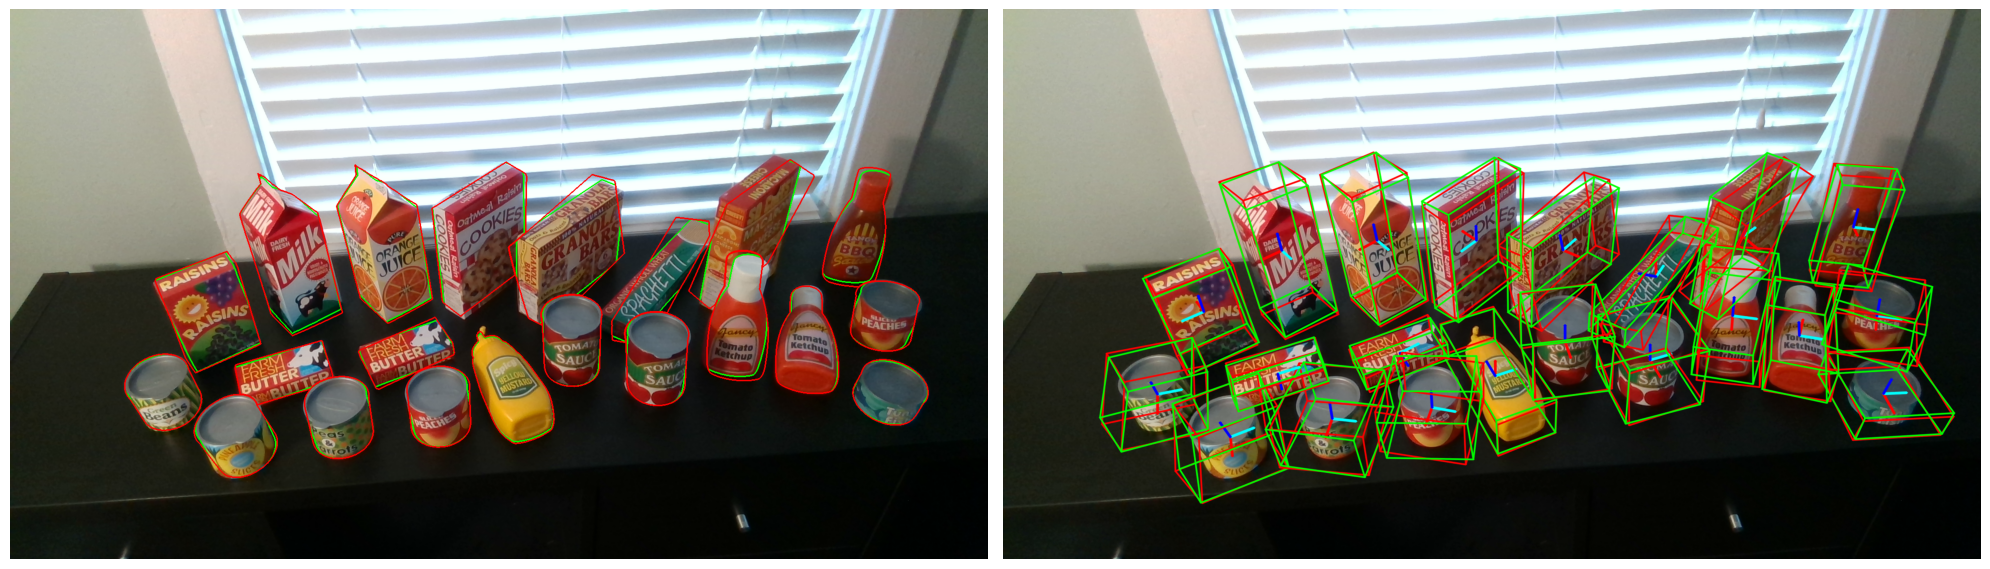

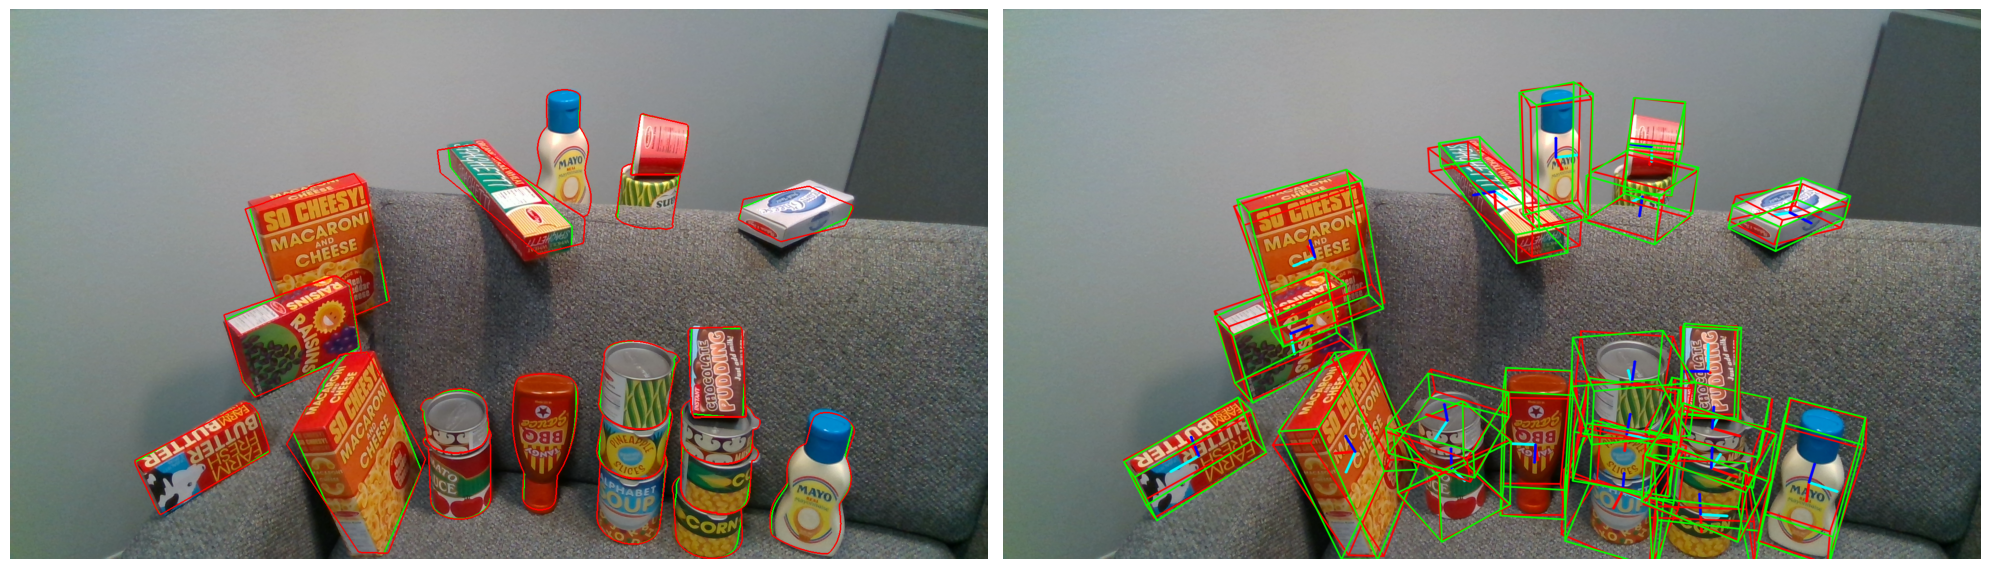

In [5]:
def plot_rgb(rgb, ax=None, num_cols=1, figsize=(10, 5)):
    if ax is None:
        fig, ax = plt.subplots(1, num_cols, figsize=figsize)
        ax.axis("off")
    res = adjust_img_for_plt(rgb)
    ax.imshow(res)
    return ax


for i, scene_res in enumerate(res_all):

    (scene_id, im_id) = (scene_res["scene_id"], scene_res["im_id"])
    res_per_obj_gt = scene_res["res_gt"]["res_per_obj"]
    res_per_obj = scene_res["res"]["res_per_obj"]
    rgb = scene_res["rgb"]
    depth = scene_res["depth"]
    cam = scene_res["cam"]
    hw = rgb.shape[:2]

    bres = get_depth_map_and_obj_masks_from_renderings(res_per_obj)
    bres_gt = get_depth_map_and_obj_masks_from_renderings(res_per_obj_gt)
    depth_map = bres["depth_map"]
    mask_objs = bres["mask_objs"]
    depth_map_gt = bres_gt["depth_map"]
    mask_objs_gt = bres_gt["mask_objs"]
    gt_poses_ordered = [v["pose"] for oidx, v in res_per_obj_gt.items()]

    contour_img = copy.deepcopy(rgb)
    for idx, gt_pose_ in enumerate(tqdm(gt_poses_ordered[:], desc="contour")):
        gt_pose_mat = pose_dict_to_mat(res_per_obj_gt[idx]["pose"])
        mesh = trimesh.Trimesh(
            vertices=models[gt_pose_["obj_id"]]["pts"],
            faces=models[gt_pose_["obj_id"]]["faces"],
        )
        depth_obj_gt = res_per_obj_gt[idx]["depth"]
        depth_obj = res_per_obj[idx]["depth"]
        depth_obj_mask = depth_obj_gt > 0
        mask_obj = mask_objs[idx]

        percent = calc_mask_visib_percent(mask_obj, depth_obj_mask)
        if percent < 20:
            print(f"{idx=} {percent=}")
            continue

        rendered, contour_img = draw_pose_contour(
            contour_img,
            cam,
            gt_pose_mat,
            contour_color=(0, 255, 0),
            mesh=mesh,
            headless=False,
            mask_visib=mask_obj,
            render_out={
                "color": res_per_obj_gt[idx]["rgb"],
                "depth": depth_obj_gt,
            },
        )
        est_pose_mat = pose_dict_to_mat(res_per_obj[idx]["pose"])
        rendered, contour_img = draw_pose_contour(
            contour_img,
            cam,
            est_pose_mat,
            contour_color=(255, 0, 0),
            mesh=mesh,
            headless=False,
            mask_visib=mask_obj,
            render_out={
                "color": res_per_obj[idx]["rgb"],
                "depth": depth_obj,
            },
        )
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    plot_rgb(contour_img, ax=axs[0])

    bbox_img = copy.deepcopy(rgb)
    for idx, gt_pose_ in enumerate(tqdm(gt_poses_ordered[:], desc="bbox")):

        obj_id = res_per_obj_gt[idx]["pose"]["obj_id"]
        pose_gt = res_per_obj_gt[idx]["pose"]
        pose_est = res_per_obj[idx]["pose"]
        model = models[obj_id]
        pts = model["pts"]
        mesh = trimesh.Trimesh(vertices=pts, faces=model["faces"])
        bbox_3d = trimesh.bounds.corners(mesh.bounding_box_oriented.bounds)
        depth_obj_gt = res_per_obj_gt[idx]["depth"]
        depth_obj_mask = depth_obj_gt > 0
        mask_obj = mask_objs[idx]
        percent = calc_mask_visib_percent(mask_obj, depth_obj_mask)
        if percent < 35:
            print(f"{idx=} {percent=}")
            continue

        syms = misc.get_symmetry_transformations(
            models_info[obj_id], max_sym_disc_step=0.01
        )
        pts_est = misc.transform_pts_Rt(pts, pose_est["R"], pose_est["t"].squeeze())
        gt_poses_syms = []
        es = []
        for sym in syms:
            R_gt_sym = pose_gt["R"].dot(sym["R"])
            t_gt_sym = pose_gt["R"].dot(sym["t"].squeeze()) + pose_gt["t"].squeeze()
            pts_gt_sym = misc.transform_pts_Rt(pts, R_gt_sym, t_gt_sym)
            gt_poses_syms.append({"R": R_gt_sym, "t": t_gt_sym, "obj_id": obj_id})
            es.append(np.linalg.norm(pts_est - pts_gt_sym, axis=1).max())
        best_idx = np.argmin(es)
        pose_gt_sym = gt_poses_syms[best_idx]
        pose_gt_sym_mat = pose_dict_to_mat(pose_gt_sym)

        est_pose_mat = pose_dict_to_mat(res_per_obj[idx]["pose"])
        bbox_img = draw_pose_on_img(
            bbox_img,
            pose_pred=est_pose_mat,
            pose_gt=pose_gt_sym_mat,
            K=cam,
            axes_scale=50 // 2,
            mesh_bbox=bbox_3d,
            bbox_color=(255, 0, 0),
            bbox_color_gt=(0, 255, 0),
        )

    plot_rgb(bbox_img, ax=axs[1])
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()